# Subway Delays in the City of Toronto



What are the reasons behind the delays in the TTC (Toronto Transit Commission) service?

Several outlets, like CBC, have reported on the reasons as to why transportation suffers delays in the city of Toronto. 

However, what sparked my interested in this topic, as well as living in Toronto and having suffered delays more than once, is this article published on RocketmapApp and titled ['What really causes TTC subway delays in Toronto?'](https://rocketmanapp.com/blog/what-really-causes-ttc-subway-delays-in-toronto/). Using a [CBC story titled '66% of subway delays are caused by passengers, CBC Toronto data analysis shows'](https://www.cbc.ca/news/canada/toronto/ttc-subway-delays-1.4068358) as a framework, which analyzes data from the TTC, the article lists the main reasons behind transportation delays. The CBC story was published in early 2017, so it used data from 2016. 

The makeup of subway delays in 2016, and according to CBC, goes as follows:

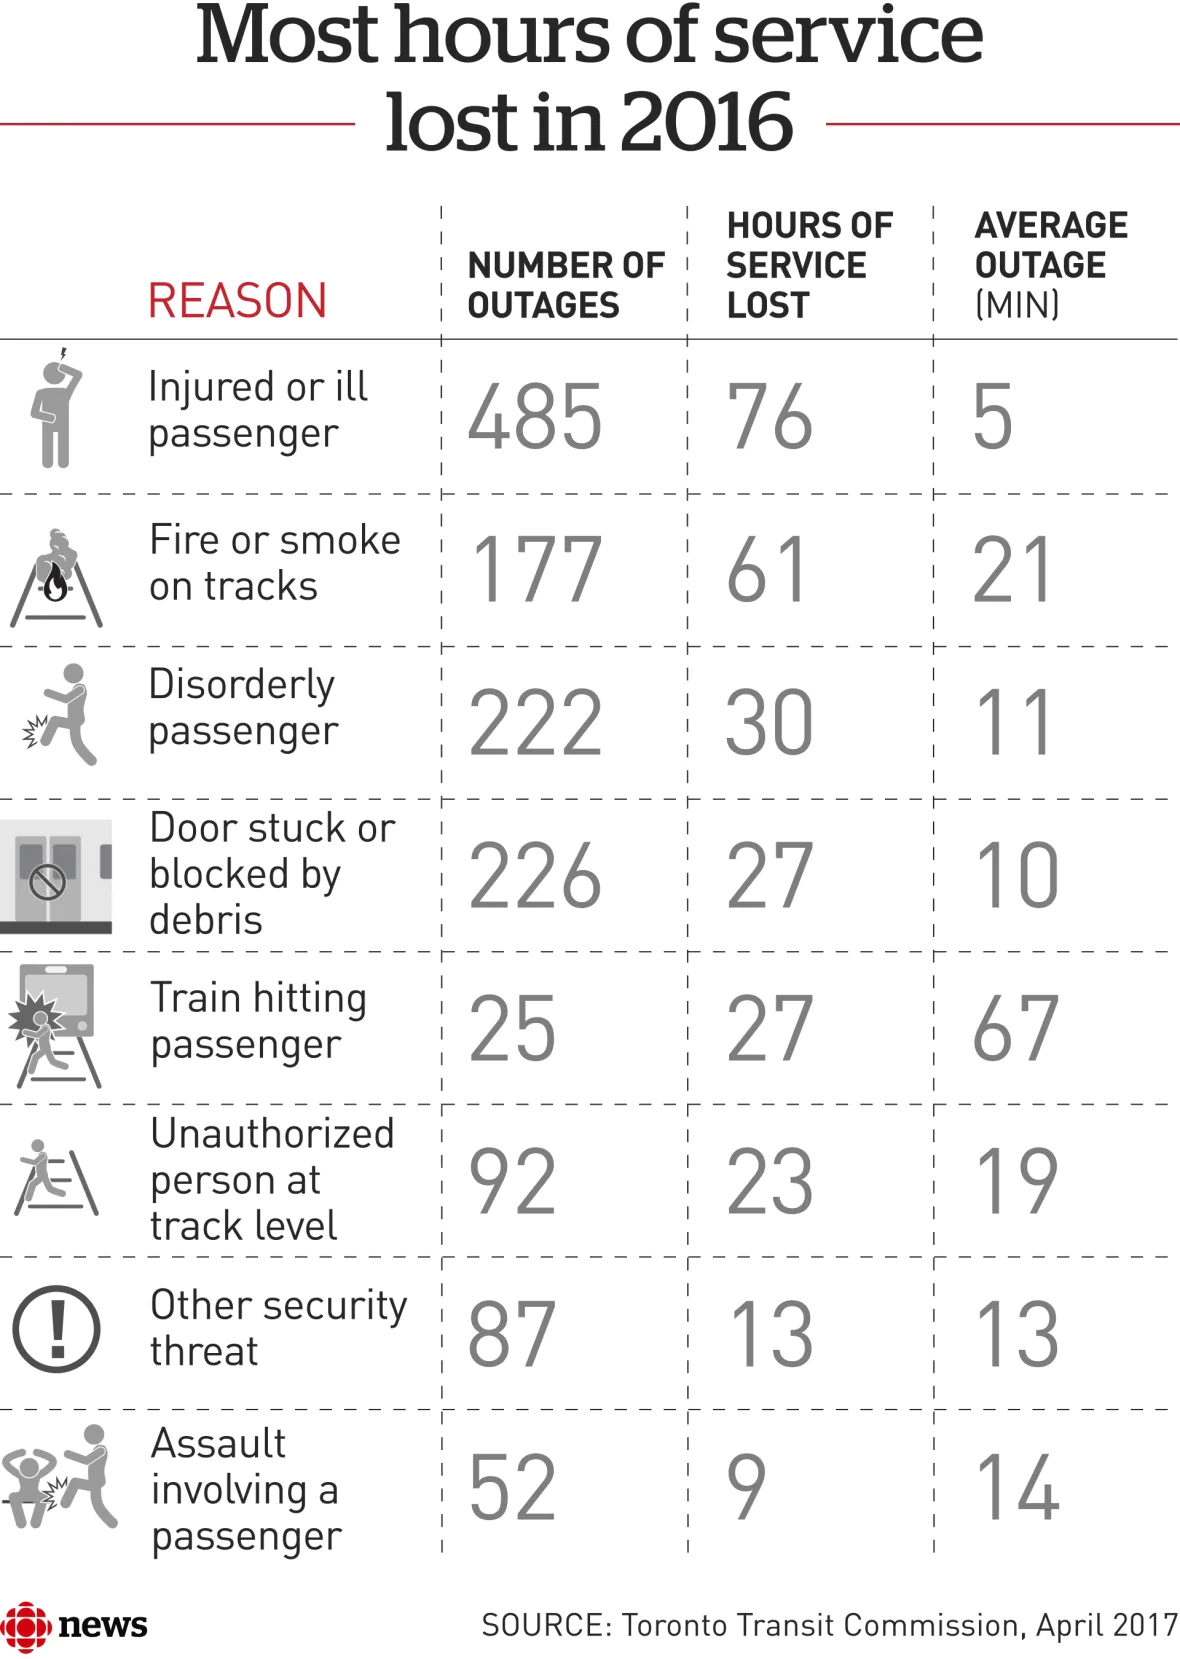

CBC has kept publishing stories on the subways delays, like ths one stating [the effects of trespassing](https://www.cbc.ca/news/canada/toronto/ttc-trespassing-campaign-1.5011407). Or this one, about an exceptional morning of [delays in January 2019](https://www.cbc.ca/news/canada/toronto/ttc-delay-video-1.5099864), caused by mechanical failures. 

With that in mind, the goal of this report is to make an exploratory analysis of the delays that happened in the last five years in Toronto using the records available on the City of Toronto Open Data Catalogue under the ['TTC Subway Delay Data.'](https://open.toronto.ca/dataset/ttc-subway-delay-data/), as well as the data present in ['Toronto Subay Delay Data'](https://www.kaggle.com/jsun13/toronto-subway-delay-data) by [Joshua Sun](https://www.kaggle.com/jsun13) on Kaggle.

Having comprehensive yet not full historic records (data only spans until September 2021), I want to examine the trends until then and forecast the possible outcome of the rest of the year.

## Data Preprocessing

The Kaggle notebook I have referenced above contains a data set with subway delay records from January 2014 to June 2021. August and September 2021 are not included, which I would circunvene by concatenating the 'big' data set with the monthly ones.

In [5]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#create four different dataframes
dfb = pd.read_csv(r"C:\Users\migue\OneDrive\Desktop\Bootcamp Projects\TTC-Delays\TTC Subway Delay Logs\Toronto-Subway-Delay-Jan-2014-Jun-2021.csv")
dfj = pd.read_csv(r"C:\Users\migue\OneDrive\Desktop\Bootcamp Projects\TTC-Delays\TTC Subway Delay Logs\subway-srt-logs-july-2021 - July 21.csv")
dfa = pd.read_csv(r"C:\Users\migue\OneDrive\Desktop\Bootcamp Projects\TTC-Delays\TTC Subway Delay Logs\subway-srt-logs-august-2021 - August 21.csv")
dfs = pd.read_csv(r"C:\Users\migue\OneDrive\Desktop\Bootcamp Projects\TTC-Delays\TTC Subway Delay Logs\subway-srt-logs-september-2021 - Sept 21.csv")

In [7]:
#concatenate the dataframes into one
df = pd.concat([dfb, dfj, dfa, dfs])
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014/01/01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111
1,2014/01/01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001
2,2014/01/01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0
3,2014/01/01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116
4,2014/01/01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386


In [8]:
df.tail()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
1428,2021/09/30,23:29,Thursday,VAUGHAN MC STATION,TUNOA,3,6,S,YU,5476
1429,2021/09/30,00:40,Thursday,DUNDAS STATION,MUIS,0,0,NaN,YU,0
1430,2021/09/30,01:46,Thursday,PAPE STATION,SUUT,11,18,W,BD,5259
1431,2021/09/30,16:04,Thursday,BAYVIEW STATION,EUSC,0,0,E,SHP,6176
1432,2021/09/30,18:40,Thursday,SHEPPARD-YONGE STATION,MUSC,0,0,E,SHP,6171


In [9]:
#rendering generalities of the working df
df.describe()

,Min Delay,Min Gap,Vehicle
count,147867.000000,147867.000000,147867.000000
mean,2.217134,3.295340,3927.670582
std,8.819347,9.130946,2454.185162
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,5210.000000
75%,3.000000,6.000000,5596.000000
max,999.000000,999.000000,72537.000000


In [10]:
df.shape

(147867, 10)

#### Dealing with Nulls

In [11]:
#check null values in data frame
df.isnull().sum()

Date             0
Time             0
Day              0
Station          0
Code             1
Min Delay        0
Min Gap          0
Bound        33296
Line           552
Vehicle          0
dtype: int64

Before focusing on the dimensions and their data types, I want to check out the amount of null values in the data frame. 

Two dimensions present values striking, at first sight. Those are the 'Bound' and 'Line' columns. I don't have metadata to resort to (the only thing closer to that is the 'Subway Delay Codes' table. More on that later.), so I can only guess what they mean. It's quite obvious they mean were the train is headed at (for 'Bound'), and what line is it (for 'Line'). While these two assumptions seem correct, having the full picture by having a council/TTC-approved definition would be of so much help. Having said that, I want to assess the proportion of nulls for the two outstanding dimensions.

In [12]:
#assessing the percentage of nulls for each column
print('Pct of nulls in Bound dimension:',df['Bound'].isnull().sum() / len(df['Bound'])*100,' ',
     'Pct of nulls in Line dimension:',df['Line'].isnull().sum() / len(df['Line'])*100)

Pct of nulls in Bound dimension: 22.517532647581948   Pct of nulls in Line dimension: 0.3733084461035931


Let's stay a little longer on this excursion on null values. The percentage is significative low for 'Line', which means there is not a large chucnk if missing values for that column. While something similar can be said of 'Bound', the percentage is higher. That there is about a 22,5% of missing values for that column, that indicates the direction in which a delayed train is supposed to be going, does not sit all that right with me.

What can be done to deal with the missing values there?

In [13]:
#assessing the mode of the values
df['Bound'].mode()

0    S
dtype: object

The list of missing values, if we recall it, shows that there are as many NaN values (33296) as there are values in the most frequent category. More, actually.

Trains southbound are the most frequent in the distrubution. Would it make sense to fill the missing values with the most frequent one? It is one approach, but that does not mean that a delay record is bound south. Are there any sensible approaches in this case? Dropping the missing values in 'Bound'?

I could remove the null values in the column, but if I wanted to explore and/or make predictions about delays in terms where the train is headed to, removing all those values could weaken both the exploration and any models.

In [14]:
#the mode has been established, check for distribution of values
df['Bound'].value_counts()

S    31514
W    29236
E    27399
N    26300
B      117
Y        2
0        1
5        1
R        1
Name: Bound, dtype: int64

In [15]:
#extract the case for Station with NaN as a value for Bound
#as stated earlier, there are 33296 null values
df['Bound'].isnull().value_counts()

False    114571
True      33296
Name: Bound, dtype: int64

This being the distribution of nulls in relation to actual values, let's see how we can get yet a closer view of what are the lines and stations of the delayed trains we don't know the direction of still.

In [16]:
#select rows in Line column for there are NaN values in Bound and vehicle number
line_bound_nan = df[(df['Bound'].isnull()) & (df['Line'].isnull()) & df['Vehicle'].notnull()]
line_bound_nan

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
500,2014/01/09,14:31,Thursday,FINCH STATION,MUIR,0,0,NaN,NaN,0
677,2014/01/13,06:30,Monday,QUEEN STATION,MUNCA,0,0,NaN,NaN,0
907,2014/01/17,08:13,Friday,DON MILLS STATION,MUO,0,0,NaN,NaN,0
1181,2014/01/22,05:10,Wednesday,YONGE BD STATION,MUNCA,0,0,NaN,NaN,0
1426,2014/01/27,05:15,Monday,QUEEN STATION,MUNCA,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1153,2021/08/29,15:49,Sunday,YORKDALE STATION,SUPOL,0,0,NaN,NaN,0
1154,2021/08/29,16:13,Sunday,YORK MILLS STATION,MUO,0,0,NaN,NaN,0
32,2021/09/01,20:35,Wednesday,MAIN STREET AND UNION,MUO,0,0,NaN,NaN,0
41,2021/09/01,22:14,Wednesday,UNION AND KENNEDY STAT,MUO,0,0,NaN,NaN,0


We finally got to see what stations and lines (and even vehicles, although there is something interesting about vehicles that I will mentioned at the the end of this paragraph) have missing values when it comes to the direction they are headed to. The problem is that a train can go into multiple directions, given a station/line (a train in Chester station, which pertains to the Bloor-Danforth line, can either be delayed going eastbound or westbound. A station like Bloor-Yonge, is the intersection of multiple lines, which adds to the issue), thus making modal imputation a no-go. More interestingly, there is a 0 in 'Vehicle' for every 'NaN' in 'Bound.'

We can assume the missing values to be missing at random (MAR), as the missingness of it might be related to a factor that has been observed in the data set. At this point, it would make sense to think that the instances with missing data were collected assuming that the rest of variables recorded would provide enough information. Another line of thought, kind of backed by the abscence of a vehicle or the delayed and gap minutes being 0.

If delay is 0, and gap 0 as well, is there a delay at all? Given these circumsnstance, maybe the best is to either delete the records, listwise, or to try extracting some from the whole data set, but re labelling NaNs as 'unknowns.'

In [17]:
#turn the NaN into a label of themsleves, Unknown
df['Bound'] = df['Bound'].fillna('Unknown')
df['Line'] = df['Line'].fillna('Unknown')

### Moving On with the Preprocessing, Once Nulls Are Sorted Out

A decision has been made on the null values. Let's now check out the data types for each dimension, and see if any transformation is needed.

In [18]:
#check the data types
df.dtypes

Date         object
Time         object
Day          object
Station      object
Code         object
Min Delay     int64
Min Gap       int64
Bound        object
Line         object
Vehicle       int64
dtype: object

As stated above, the data set includes historical records, and to make the exploration useful, all time-related dimensiones have to be converted to 'time' data types, as they now are taken as object-type types.

In [19]:
#conversion to datetime for Date dimension
df['Date'] = pd.to_datetime(df['Date'])

Having a date with day, month and year, we can increase the granularity of the analysis by creating new columns for month, and year.

In [20]:
#create new dimensions for motnh and year
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [21]:
#check wether new colums are there and the distribution of data types
df.dtypes

Date         datetime64[ns]
Time                 object
Day                  object
Station              object
Code                 object
Min Delay             int64
Min Gap               int64
Bound                object
Line                 object
Vehicle               int64
Month                 int64
Year                  int64
dtype: object

### Making sense of the codes

With the 'time' dimensions cleared, I would like to shift my attention to one dimension that would help in understanding the delay taxonomy. That is the dimensions under the name of 'Code.'

In [22]:
df['Code'].value_counts()

MUSC     19938
TUSC     14510
MUIS     10276
MUPAA     9717
SUDP      7886
         ...  
ERTO         1
MTAFR        1
TRDOE        1
STO          1
SFAP         1
Name: Code, Length: 219, dtype: int64

At this point, it is of use to retrieve the data set at the Open Data Portal of the City of Toronto titled 'Subway Delay Codes', that accounts for the causes that lead to delays.

In [23]:
sdc = pd.read_csv(r"C:\Users\migue\OneDrive\Desktop\Bootcamp Projects\TTC-Delays\TTC Subway Delay Logs\Subway Delay Codes.csv")
#drop blank columns
sdc.drop(columns = ['Unnamed: 0', 'Unnamed: 1','Unnamed: 4', 'Unnamed: 5'], inplace= True)

In [24]:
#check if all the fluff is gone
sdc.shape
sdc

,Unnamed: 2,Unnamed: 3,Unnamed: 6,Unnamed: 7
0,SUB RMENU CODE,CODE DESCRIPTION,SRT RMENU CODE,CODE DESCRIPTION
1,EUAC,Air Conditioning,ERAC,Air Conditioning
2,EUAL,Alternating Current,ERBO,Body
3,EUATC,ATC RC&S Equipment,ERCD,Consequential Delay (2nd Delay Same Fault)
4,EUBK,Brakes,ERCO,Couplers
...,...,...,...,...
125,TUS,Crew Unable to Maintain Schedule,NaN,NaN
126,TUSC,Operator Overspeeding,NaN,NaN
127,TUSET,Train Controls Improperly Shut Down,NaN,NaN
128,TUST,Storm Trains,NaN,NaN


In [25]:
#the df was created with no headers, let's create a variable containing the column names of interest and add such names to the df
headers = ['SUB RMENU CODE', 'CODE DESCRIPTION SUB','SRT RMENU CODE','CODE DESCRIPTION SRT']
sdc.columns = headers

In [26]:
sdc

,SUB RMENU CODE,CODE DESCRIPTION SUB,SRT RMENU CODE,CODE DESCRIPTION SRT
0,SUB RMENU CODE,CODE DESCRIPTION,SRT RMENU CODE,CODE DESCRIPTION
1,EUAC,Air Conditioning,ERAC,Air Conditioning
2,EUAL,Alternating Current,ERBO,Body
3,EUATC,ATC RC&S Equipment,ERCD,Consequential Delay (2nd Delay Same Fault)
4,EUBK,Brakes,ERCO,Couplers
...,...,...,...,...
125,TUS,Crew Unable to Maintain Schedule,NaN,NaN
126,TUSC,Operator Overspeeding,NaN,NaN
127,TUSET,Train Controls Improperly Shut Down,NaN,NaN
128,TUST,Storm Trains,NaN,NaN


In [27]:
#remove redundant row
sdc.drop([0])

,SUB RMENU CODE,CODE DESCRIPTION SUB,SRT RMENU CODE,CODE DESCRIPTION SRT
1,EUAC,Air Conditioning,ERAC,Air Conditioning
2,EUAL,Alternating Current,ERBO,Body
3,EUATC,ATC RC&S Equipment,ERCD,Consequential Delay (2nd Delay Same Fault)
4,EUBK,Brakes,ERCO,Couplers
5,EUBO,Body,ERDB,Disc Brakes
...,...,...,...,...
125,TUS,Crew Unable to Maintain Schedule,NaN,NaN
126,TUSC,Operator Overspeeding,NaN,NaN
127,TUSET,Train Controls Improperly Shut Down,NaN,NaN
128,TUST,Storm Trains,NaN,NaN


Now, the data available does not explain why are there SRT and SUB descriptions and codes. Do SUB and SRT refer to different levels? The codes, while different, refer to the same situations, the point of origin being different?

In [28]:
#counting the amount of codes per column
print('SUB CODES:', sdc['SUB RMENU CODE'].count(), 
'SRT CODES:', sdc['SRT RMENU CODE'].count())

SUB CODES: 130 SRT CODES: 72


There is an obvious difference in the number of codes, in favor of the SUB category. It follows, then, that there are more descriptions for SUB than for SRT. Going over the descriptions, there seems to be some coincidences in the description.

Let's compare both columns and see where the differences are, aside from the obvious amount difference (already noted with NaNs).

In [29]:
compare_columns = np.where(sdc['CODE DESCRIPTION SUB'] == sdc['CODE DESCRIPTION SRT'], True, False)
#add the column to the dataframe
sdc['EQUAL?'] = compare_columns
sdc

,SUB RMENU CODE,CODE DESCRIPTION SUB,SRT RMENU CODE,CODE DESCRIPTION SRT,EQUAL?
0,SUB RMENU CODE,CODE DESCRIPTION,SRT RMENU CODE,CODE DESCRIPTION,True
1,EUAC,Air Conditioning,ERAC,Air Conditioning,True
2,EUAL,Alternating Current,ERBO,Body,False
3,EUATC,ATC RC&S Equipment,ERCD,Consequential Delay (2nd Delay Same Fault),False
4,EUBK,Brakes,ERCO,Couplers,False
...,...,...,...,...,...
125,TUS,Crew Unable to Maintain Schedule,NaN,NaN,False
126,TUSC,Operator Overspeeding,NaN,NaN,False
127,TUSET,Train Controls Improperly Shut Down,NaN,NaN,False
128,TUST,Storm Trains,NaN,NaN,False


In [30]:
#clean redundant values at the first row
sdc.drop([0], inplace = True)

In [31]:
sdc['EQUAL?'].value_counts()

False    128
True       1
Name: EQUAL?, dtype: int64

Only 1 value is coincidental, then. How about merging everything together to get the full picture? First, I am going to put together all codes in one column. I will do the same for code descriptions.

In [32]:
sdc['Code'] = sdc['SUB RMENU CODE'].combine_first(sdc['SRT RMENU CODE'])
sdc['Code Description'] = sdc['CODE DESCRIPTION SUB'].combine_first(sdc['CODE DESCRIPTION SRT'])
sdc.drop(columns = (['CODE DESCRIPTION SRT','SUB RMENU CODE', 'CODE DESCRIPTION SUB','SRT RMENU CODE', 'EQUAL?']), inplace = True)

With the above table ready, I am going to merge it into my working data set.

In merging, I want to keep the values of all the records, to have the full picture, times-series wise. Thus, the perge is left-sided.

In [33]:
df = df.merge(sdc, how = 'left', on = 'Code')
df

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Month,Year,Code Description
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,1,2014,Priority One - Train in Contact With Person
1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,1,2014,Disorderly Patron
2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,Unknown,YU,0,1,2014,NaN
3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,1,2014,Disorderly Patron
4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,1,2014,Unsanitary Vehicle
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147862,2021-09-30,23:29,Thursday,VAUGHAN MC STATION,TUNOA,3,6,S,YU,5476,9,2021,No Operator Immediately Available
147863,2021-09-30,00:40,Thursday,DUNDAS STATION,MUIS,0,0,Unknown,YU,0,9,2021,Injured or ill Customer (In Station) - Transpo...
147864,2021-09-30,01:46,Thursday,PAPE STATION,SUUT,11,18,W,BD,5259,9,2021,Unauthorized at Track Level
147865,2021-09-30,16:04,Thursday,BAYVIEW STATION,EUSC,0,0,E,SHP,6176,9,2021,Speed Control Equipment


The working data frame is almost ready, but there are still a few things I would like to tweak in the preprocessing phase.
Namely, I would like to make dates the index for my data frame.

In [34]:
df = df.set_index(df['Date'])
#index and first column share same name, information and purposes, remove the duplicate
df.drop(columns = (['Date']), inplace = True)

In [35]:
df.head()

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Month,Year,Code Description
Date,,,,,,,,,,,,
2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,1,2014,Priority One - Train in Contact With Person
2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,1,2014,Disorderly Patron
2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,Unknown,YU,0,1,2014,NaN
2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,1,2014,Disorderly Patron
2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,1,2014,Unsanitary Vehicle


An index is now set up. Let's re check again the data types of the frame.

In [36]:
df['Year'] = df.index.year
df['Month'] = df.index.month

In [37]:
df.head()

,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Month,Year,Code Description
Date,,,,,,,,,,,,
2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,1,2014,Priority One - Train in Contact With Person
2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,1,2014,Disorderly Patron
2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,Unknown,YU,0,1,2014,NaN
2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,1,2014,Disorderly Patron
2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,1,2014,Unsanitary Vehicle


This being the working data frame, I amn going to export it to a CSV and add it to the assets of its project. 

In [38]:
#exporting working data frame to CSV
df.to_csv(r"C:\Users\migue\Downloads\delay_working_df.csv")

Also, the data frame in which I joined all the records available, I am going to export as well.

In [39]:
df.to_csv(r"C:\Users\migue\Downloads\delay_working_df.csv")

### Exploring and Visualizing Delays between Januray 2014 and September 2021

First, I would like to get an overview of the total delay time over the years. The first variable I am going to look at is the total minute delays per year.

<AxesSubplot:xlabel='Year', ylabel='Total Minute Delays'>

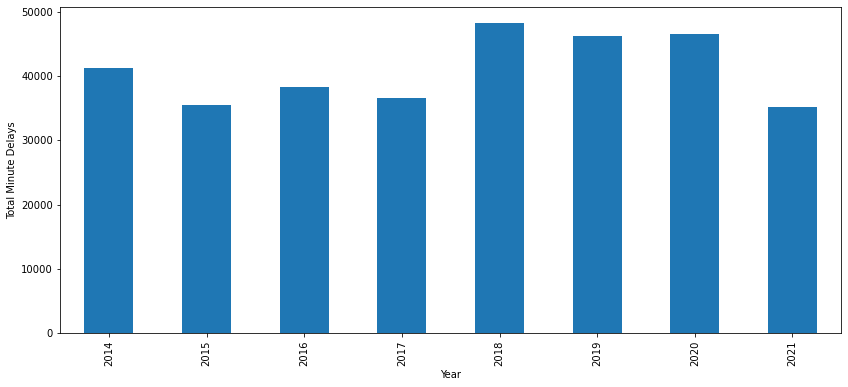

In [40]:
delay_sum = df.groupby('Year')['Min Delay'].sum()
delay_sum.plot(kind='bar', figsize=(14,6), ylabel='Total Minute Delays')

In [41]:
delay_sum = pd.DataFrame(delay_sum)
delay_sum

,Min Delay
Year,
2014,41177
2015,35499
2016,38275
2017,36580
2018,48278
2019,46241
2020,46572
2021,35219


<AxesSubplot:xlabel='Date', ylabel='Total Minute Delays'>

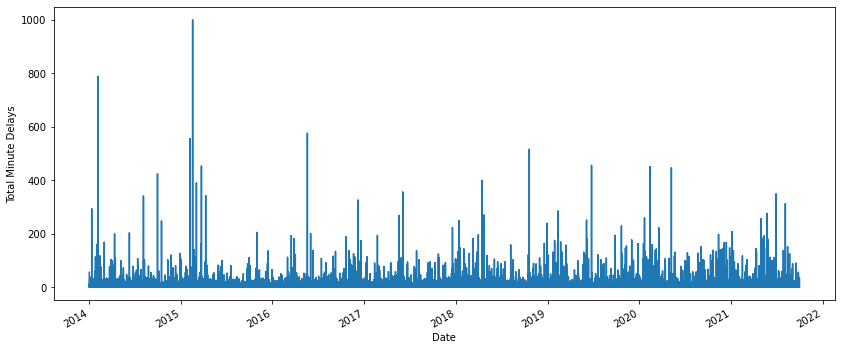

In [42]:
#plot the sum of minute delays over time using a line plot
df['Min Delay'].plot(kind='line', figsize=(14,6), ylabel='Total Minute Delays')

While data is incomplete for 2021, there seens to be upward trend in the last years in terms of total minutes of delay.

What's the average delay every year?

In [43]:
delay_mean = df.groupby('Year')['Min Delay'].mean()

In [44]:
delay_mean

Year
2014    2.016108
2015    1.653115
2016    1.808666
2017    1.936987
2018    2.328109
2019    2.405629
2020    3.150589
2021    3.149897
Name: Min Delay, dtype: float64

<AxesSubplot:xlabel='Year'>

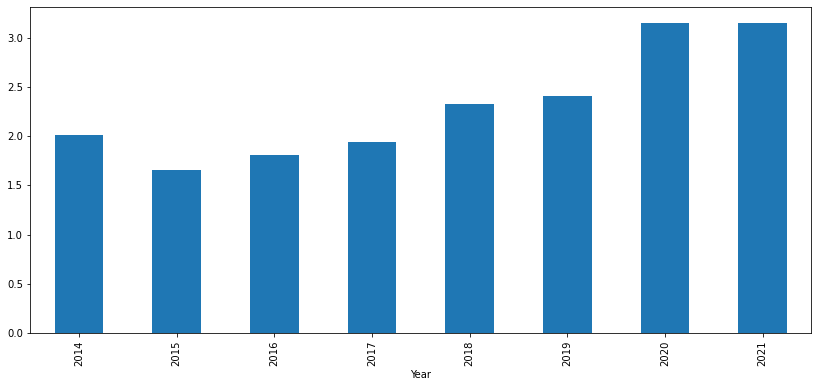

In [45]:
delay_mean.plot(kind= 'bar', figsize=(14,6))

There has been a significant spike in average delays in the last two years.

What have been the months with highest frequency of delays?

In [46]:
df.groupby(['Month'])['Min Delay'].mean()

Month
1     2.398079
2     2.516945
3     2.258067
4     2.313767
5     2.294259
6     2.242342
7     2.069686
8     2.054988
9     2.005314
10    2.059656
11    2.109730
12    2.276536
Name: Min Delay, dtype: float64

It seems it is the coldest months of the year that have the highest average of minute delays. 

Another interesting way of seeing the evolution of delays is to look at the daily and weekly distribution of average delays.

In [47]:
daily_delay = df[['Min Delay', 'Day']].resample('D').mean()
daily_delay

,Min Delay
Date,
2014-01-01,4.511111
2014-01-02,2.092105
2014-01-03,2.803571
2014-01-04,2.060606
2014-01-05,2.558824
...,...
2021-09-26,3.145833
2021-09-27,3.000000
2021-09-28,2.543860


In [48]:
weekly_delay = df[['Min Delay', 'Day']].resample('W').mean()
weekly_delay

,Min Delay
Date,
2014-01-05,2.762295
2014-01-12,3.147196
2014-01-19,1.709770
2014-01-26,2.185930
2014-02-02,2.725624
...,...
2021-09-05,2.955975
2021-09-12,2.511905
2021-09-19,2.415978


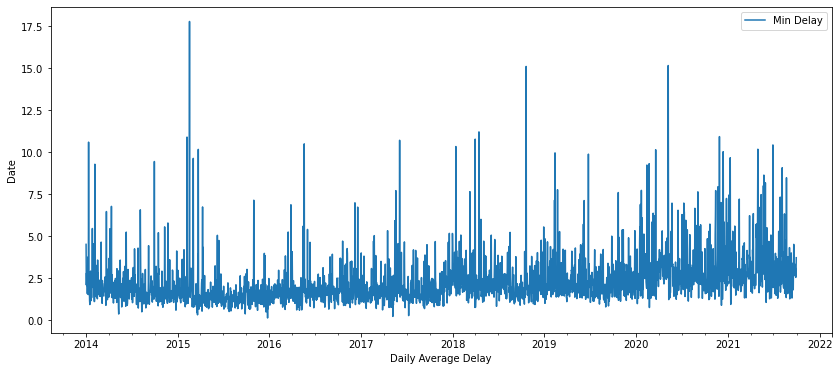

In [49]:
daily_delay.plot(figsize=(14,6), ylabel='Date', xlabel='Daily Average Delay', legend=True).autoscale()

Let's see now how the weekly average looks when plotted out.

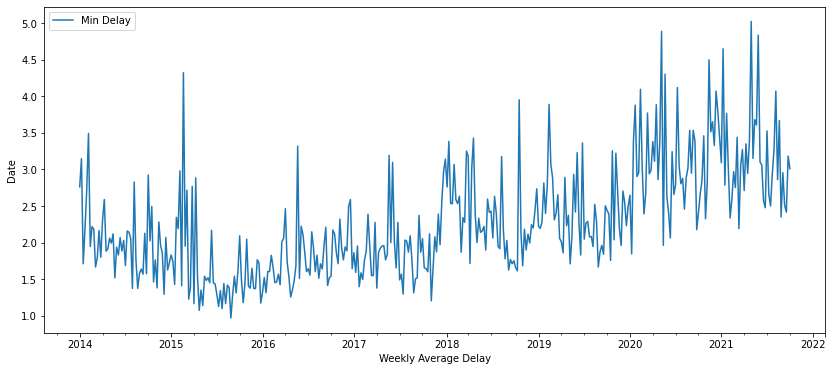

In [50]:
weekly_delay.plot(figsize=(14,6), ylabel='Date', xlabel='Weekly Average Delay', legend=True).autoscale()

While there seems to be a trend and seasonality for delays(expressed in minutes), a deeper look into it is of order.

### Assessing the Seasonality of Monthly Minute Delays

This section of the project will rely heavily on the functionalities for trend and seasonality analysis present in the statsmodels module. Thus, I will first start by importing the libraries needed.

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

While the previous resampling and plotting of daily and weekly offer a good impression of the evolution of Let's first star by decomposing the trend and seasonal components of the dataframe. To that end, I am going to use a resampled version of the data frame, counting the total delayed minutes per day. 

In [52]:
df_total_monthly = df[['Min Delay']].resample('M').count()
df_total_monthly

,Min Delay
Date,
2014-01-31,1783
2014-02-28,1881
2014-03-31,1879
2014-04-30,1616
2014-05-31,1599
...,...
2021-05-31,1168
2021-06-30,1265
2021-07-31,1244


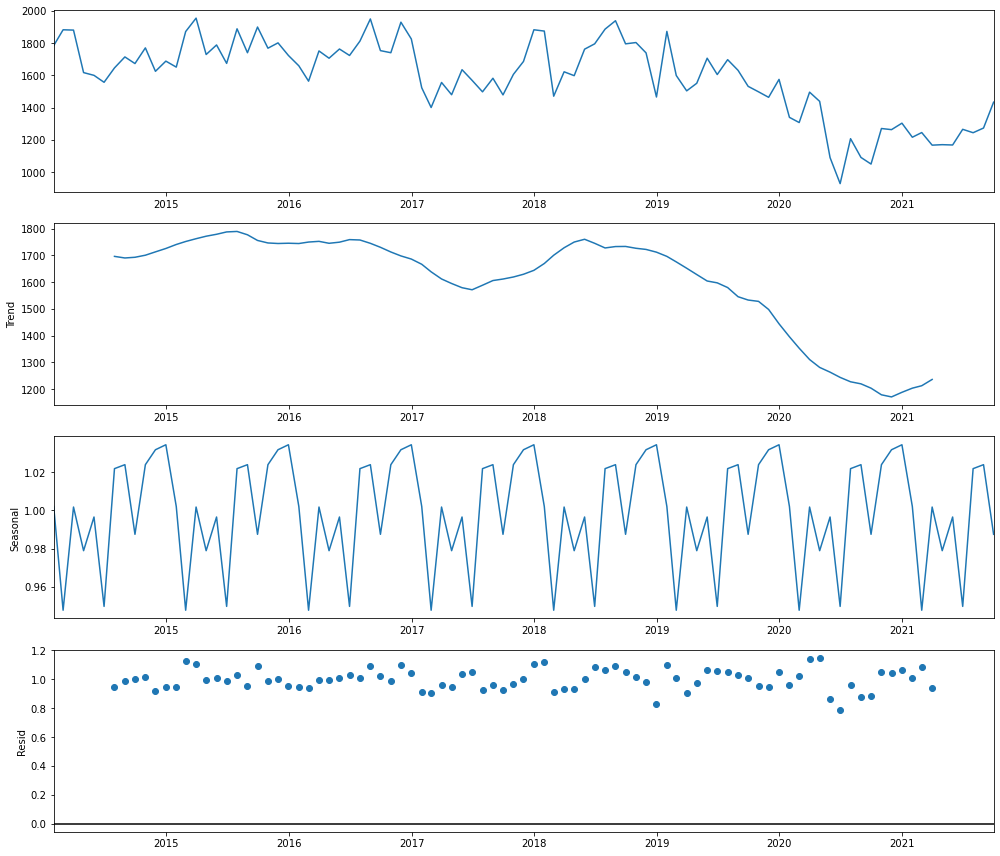

In [54]:
sdcompose = seasonal_decompose(df_total_monthly, model ='mul')
#making adjustments to render a big enough plot that represents each component faithfully
plt.rcParams['figure.figsize'] = (14, 12)
sdcompose.plot();

There being a trend, let's take a step closer to forecasting the data that is missing for the remainder of 2021 up until March 2022 (to see  while considering the most recent observations. A triple smoothing exponential moving average model (Holt-Winters) over a 12-month span is to be applied, as it accounts for trend and seasonality.

In [56]:
df_total_monthly['TES-12'] = ExponentialSmoothing(df_total_monthly, trend= 'add', seasonal='add' ,seasonal_periods=12).fit().fittedvalues
df_total_monthly

C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


,Min Delay,TES-12
Date,,
2014-01-31,1783,1753.635448
2014-02-28,1881,1789.800990
2014-03-31,1879,1901.203493
2014-04-30,1616,1720.389018
2014-05-31,1599,1677.912862
...,...,...
2021-05-31,1168,1154.537890
2021-06-30,1265,1086.906220
2021-07-31,1244,1290.857649


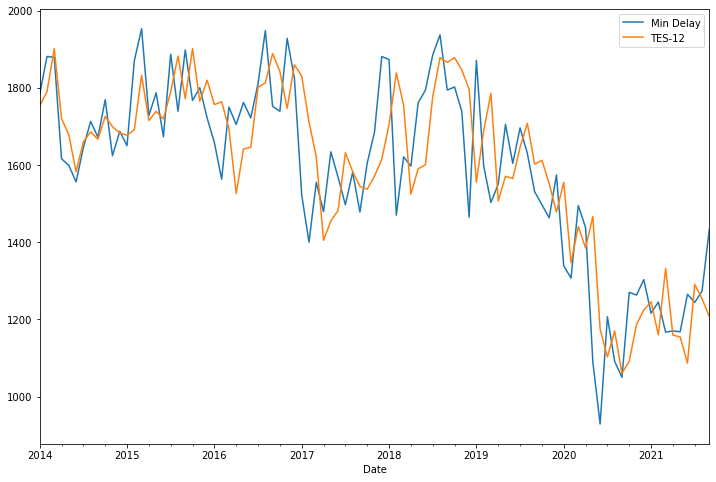

In [57]:
df_total_monthly.plot(figsize=(12,8)).autoscale(axis='x',tight=True);

It does not seem that the model is fitting the values all that well. Let's focus, regardless, on the evolution from 2020 up until September 2021, as there seems to be a downward trend there. 

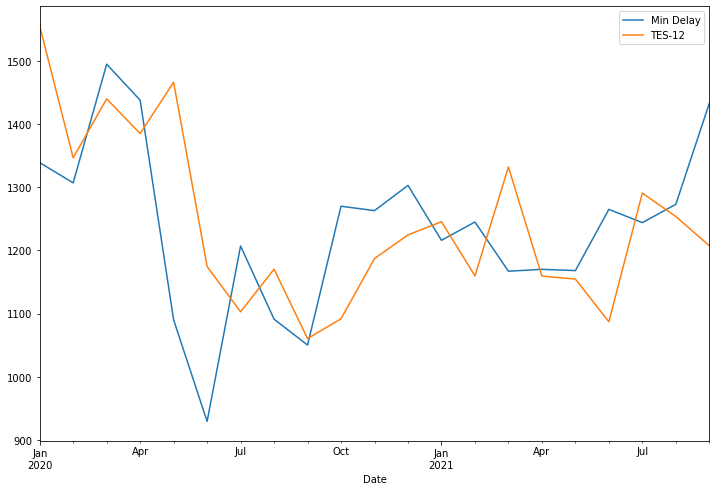

In [58]:
df_total_monthly['2020-01-01':'2021-09-30'].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

Let's see if the Holt-Winters method is helpful in forecasting the data for the remainder of 2021 and the first quarter of 2022.

In [59]:
#determine lengths for 80/20 split
print('Dataframe length:', len(df_total_monthly),' ', '20% of dataframe: ', len(df_total_monthly) * 0.25)
print(93-23)

Dataframe length: 93   20% of dataframe:  23.25
70


In [60]:
#create train and test splits, on a 80/20 split
train = df_total_monthly['Min Delay'].iloc[:70]
test = df_total_monthly['Min Delay'].iloc[70:]
print(train.shape, test.shape)

(70,) (23,)


<AxesSubplot:xlabel='Date'>

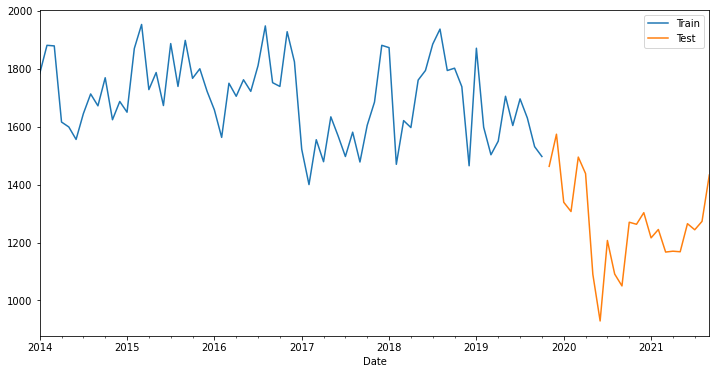

In [61]:
#plot train and test data
train.plot(legend=True, label='Train')
test.plot(figsize=(12,6), legend=True, label='Test')

In [62]:
#instantiate the model
fitted_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()

C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Now that we have a visualization of the the splits and the model has been fit, let's see how well the test set is predicted.

In [199]:
#passing 23 data points, test shape
test_predictions = fitted_model.forecast(23).rename('23-month prediction')
#print test and predicted values together
for i in range(len(test_predictions)):
    print(f"predicted={test_predictions[i]:<11.10}, expected={test[i]}")

predicted=1559.41526 , expected=1463
predicted=1485.950328, expected=1574
predicted=1549.405706, expected=1339
predicted=1322.079906, expected=1307
predicted=1418.713896, expected=1495
predicted=1415.649777, expected=1438
predicted=1532.325546, expected=1090
predicted=1449.373584, expected=929
predicted=1500.732287, expected=1207
predicted=1493.844409, expected=1091
predicted=1397.271271, expected=1050
predicted=1437.969078, expected=1270
predicted=1448.740579, expected=1263
predicted=1375.275647, expected=1303
predicted=1438.731026, expected=1216
predicted=1211.405225, expected=1245
predicted=1308.039216, expected=1167
predicted=1304.975097, expected=1170
predicted=1421.650865, expected=1168
predicted=1338.698904, expected=1265
predicted=1390.057606, expected=1244
predicted=1383.169729, expected=1273
predicted=1286.596591, expected=1433


Let's plot it all together.

<AxesSubplot:xlabel='Date'>

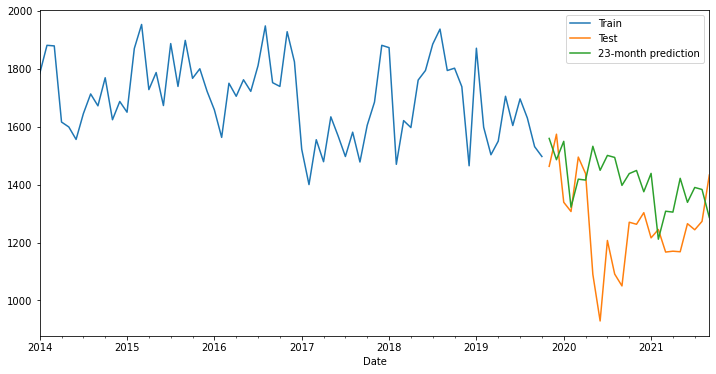

In [64]:
train.plot(legend=True, label = 'Train')
test.plot(legend=True, label = 'Test')
test_predictions.plot(legend=True, figsize=(12,6))

<AxesSubplot:xlabel='Date'>

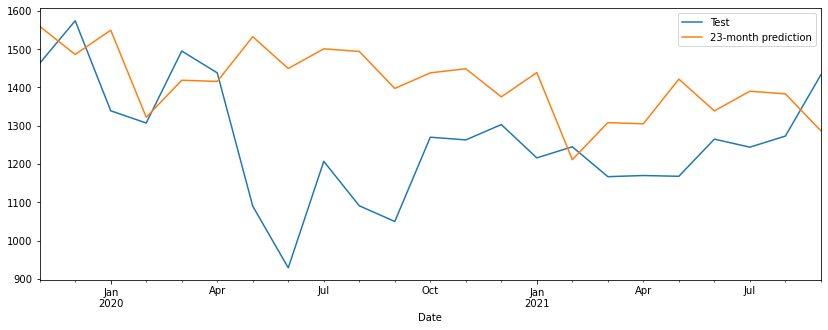

In [65]:
#zoom in on the predicted values
test.plot(legend=True, label = 'Test')
test_predictions.plot(legend=True, figsize=(14,5), xlim=['2019-11-30','2021-09-30'])

The model does not seem to fit the test values all that well. Let's pass some evalutaion metrics, like the mean absolute error and mean squared error, to determine how off the predicted values are in relation to the actual values.

In [182]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_absolute_error(test, test_predictions)

182.7582564164886

In [183]:
#calculating the mean root squared error
np.sqrt(mean_squared_error(test, test_predictions))

226.9768538058098

In [71]:
#get descriptive stats to get the mean and thus compare it to the mean squared error
test.describe()

count      23.000000
mean     1260.869565
std       152.074833
min       929.000000
25%      1169.000000
50%      1263.000000
75%      1323.000000
max      1574.000000
Name: Min Delay, dtype: float64

Thus, the mean being of 1260 delayed minutes per month, an error of 227 minutes, give or take, seems a little bit too much of an offset when tying to come up with predicted values. Being off for almost 4 hours might indicate that a Holt-Winters model to predict for delayed minutes on a montlhy basis is insufficient. 

Having said that, let's re train the data and actually get a forecast 6 months ahead, thus covering for the data not showing for 2021 and the first quarter of 2022.

In [202]:
final_model = ExponentialSmoothing(df_total_monthly['Min Delay'],trend='add',seasonal='add',seasonal_periods=12).fit()

C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [205]:
fcast= final_model.forecast(6)
fcast

2021-10-31    1393.354460
2021-11-30    1382.195572
2021-12-31    1381.854297
2022-01-31    1347.316567
2022-02-28    1295.156880
2022-03-31    1387.617133
Freq: M, dtype: float64

<AxesSubplot:title={'center':'6-month Forecast'}, xlabel='Date', ylabel='Forecasted Values'>

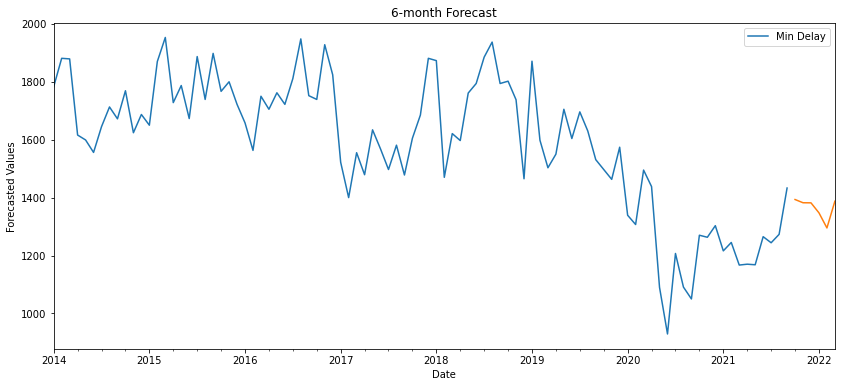

In [80]:
df_total_monthly['Min Delay'].plot(legend=True)
fcast.plot(figsize=(14, 6), ylabel='Forecasted Values', title= '6-month Forecast')

This model is forecasting the next six months to have ups and downs. Expanding on the use of moving averages to predict and forecast values, I am, at this point, going to implement an ARIMA model. 

### Predicting and Forecasting Delays Using ARIMA 

Let's see how well an autoregressive moving average model (ARIMA) does compared to the triple exponential moving average model. 

ARIMA models encompass three submodels, which are:

* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Having said that, one of the prerequisites for the implementation of an ARIMA model is to determine whether the dimension of interest is stationary. To be stationary means that there are no trends or changes within the series. One way to determine such component is to run the Augmented Dickey-Fuller test, a statistical significance test that posts a null hypothesis for non stationarity of the dimension. Rejecting it entails that the series is stationary. Also, this also gives us the value for parameter 'd' in a model, so it's worth taking a look at what the test has to say before we implement the actual model. Not only, at this point, want to to make the data stationary, I also want to extract the values of the parameters for the model before I ran a baseline automated one using pdarima, with the intent of comparing both workarounds.

In [158]:
from statsmodels.tsa.stattools import adfuller

In [157]:
adfuller(df_total_monthly['Min Delay'])

(-1.9682075342919683,
 0.30068455322178533,
 2,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 1020.0016074264734)

P-value is 0.300. There is evidence to susatin the null hypothesis, so there is reason to think the series is non-stationary.

In [119]:
from statsmodels.tsa.statespace.tools import diff
#get one order of differentiation
df_total_monthly['Diff'] = diff(df_total_monthly['Min Delay'], k_diff = 1)

In [132]:
#instead of getting rid of the NaN value that differentiating produces on the first record, replace it with 0
df_total_monthly['Diff'] = df_total_monthly['Diff'].replace('NaN', 0)
df_total_monthly['Diff']

Date
2014-01-31      0.0
2014-02-28     98.0
2014-03-31     -2.0
2014-04-30   -263.0
2014-05-31    -17.0
              ...  
2021-05-31     -2.0
2021-06-30     97.0
2021-07-31    -21.0
2021-08-31     29.0
2021-09-30    160.0
Freq: M, Name: Diff, Length: 93, dtype: float64

In [159]:
#pass the ADF test on the the differentiated values
adfuller(df_total_monthly['Diff'])

(-9.319472481583002,
 9.982475693276776e-16,
 1,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 1020.6472429324583)

There is no evidence against the null hypothesis, so it can be rejected. The data is now stationary.

The one order differentiation has worked out, as the p-value is way outside the interval of confidence. This means the value for the integrative aspect of a prospective model would be 1. Before instatiating any model, let's try obtain the values for the other two parameters, p an q. They are usually identified by plotting the auto correlation and partial auto correlation plots (ACF and PACF, respectively), as both are useful in suggesting the values for each parameter.

In [134]:
#make necessary imports
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

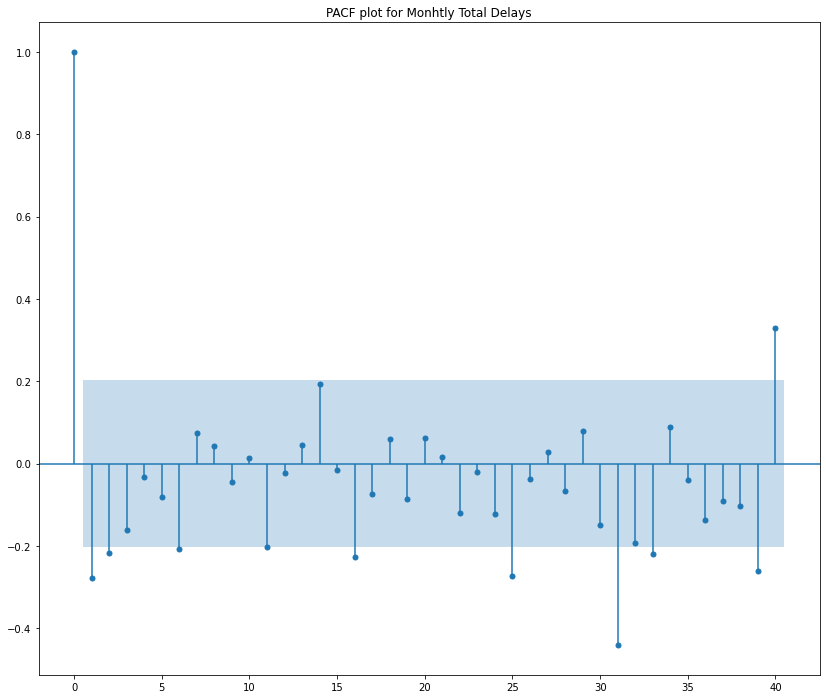

In [150]:
# plot the PACF to obtain the p orders
plot_pacf(df_total_monthly['Diff'], lags=40, title = 'PACF plot for Monhtly Total Delays');

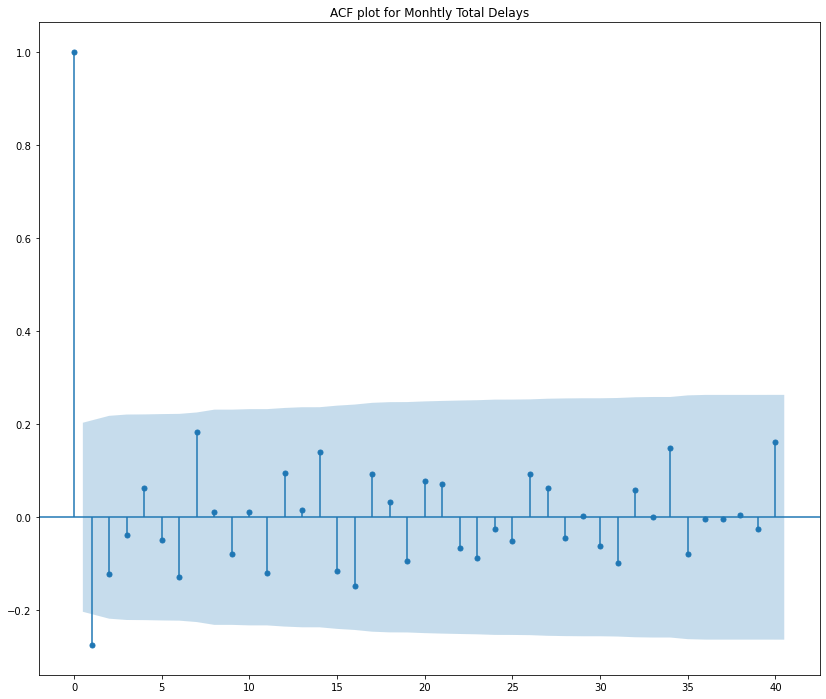

In [155]:
# plot the ACF to obtain the q orders
plot_acf(df_total_monthly['Diff'], lags=40, title = 'ACF plot for Monhtly Total Delays');

It seems that the values for all thre of the parameters is 1. It has the potential of being an ARIMA(1, 1, 1).
Let's see what auto_arima has to offer. 

In [146]:
from pmdarima import auto_arima

In [149]:
auto_arima(df_total_monthly['Min Delay']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -579.316
Date:                Thu, 17 Feb 2022   AIC                           1164.632
Time:                        16:01:42   BIC                           1172.197
Sample:                             0   HQIC                          1167.685
                                 - 93                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3430      0.182      1.885      0.059      -0.014       0.699
ma.L1         -0.7415      0.142     -5.234      0.000      -1.019      -0.464
sigma2       1.72e+04   2455.804      7.003      0.000    1.24e+04     2.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.91   Prob(JB):                         0.34
Heteroskedasticity (H):               1.36   Skew:                            -0.38
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So it seems that the order for the model is (1, 1, 1). However, while I was expecting auto_arima to render an ARIMA model, what it rendered is a SARIMAX model. SARIMAX models work bet with exogenous varaibles, and two sets of orders are usually provided. However, in this case, I am applying an ARIMA model for the delayed minutes in an attempt of predicting 23 months' worth of values and forecasting the next six months in relation to the the last data point.

In [170]:
#apply here same train/test split
train = df_total_monthly['Min Delay'].iloc[:70]
test = df_total_monthly['Min Delay'].iloc[70:]
print(train.shape, test.shape)

(70,) (23,)


In [171]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(1,1,1))
results = model.fit()
results.summary()

C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Min Delay   No. Observations:                   69
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -430.667
Method:                       css-mle   S.D. of innovations            121.336
Date:                Thu, 17 Feb 2022   AIC                            869.334
Time:                        16:53:39   BIC                            878.270
Sample:                    02-28-2014   HQIC                           872.879
                         - 10-31-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8384      1.241     -1.481      0.139      -4.272       0.595
ar.L1.D.Min Delay     0.4399      0.111      3.962      0.000       0.222       0.658
ma.L1.D.Min Delay    -0.9999      0.041    -24.517      0.000      -1.080      -0.920
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2731           +0.0000j            2.2731            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [172]:
#obtain predicted values
start = len(train)
end = len(train) + len(test) - 1
prediction = results.predict(start, end, dynamic = False, typ='levels').rename('Predicted Values for ARIMA (1,1,1)')
prediction

2019-11-30    1572.828349
2019-12-31    1605.157424
2020-01-31    1618.350113
2020-02-29    1623.124242
2020-03-31    1624.194843
2020-04-30    1623.636171
2020-05-31    1622.360744
2020-06-30    1620.769997
2020-07-31    1619.040535
2020-08-31    1617.250048
2020-09-30    1615.432715
2020-10-31    1613.603571
2020-11-30    1611.769232
2020-12-31    1609.932607
2021-01-31    1608.094977
2021-02-28    1606.256904
2021-03-31    1604.418637
2021-04-30    1602.580284
2021-05-31    1600.741893
2021-06-30    1598.903486
2021-07-31    1597.065072
2021-08-31    1595.226654
2021-09-30    1593.388235
Freq: M, Name: Predicted Values for ARIMA (1,1,1), dtype: float64

In [180]:
#print test and predicted values together
for i in range(len(prediction)):
    print(f"predicted={prediction[i]:<11.10}, expected={test[i]}")

predicted=1572.828349, expected=1463
predicted=1605.157424, expected=1574
predicted=1618.350113, expected=1339
predicted=1623.124242, expected=1307
predicted=1624.194843, expected=1495
predicted=1623.636171, expected=1438
predicted=1622.360744, expected=1090
predicted=1620.769997, expected=929
predicted=1619.040535, expected=1207
predicted=1617.250048, expected=1091
predicted=1615.432715, expected=1050
predicted=1613.603571, expected=1270
predicted=1611.769232, expected=1263
predicted=1609.932607, expected=1303
predicted=1608.094977, expected=1216
predicted=1606.256904, expected=1245
predicted=1604.418637, expected=1167
predicted=1602.580284, expected=1170
predicted=1600.741893, expected=1168
predicted=1598.903486, expected=1265
predicted=1597.065072, expected=1244
predicted=1595.226654, expected=1273
predicted=1593.388235, expected=1433


Those are the predicted values. Let's now visualize them in conjunction with the test values.

<AxesSubplot:title={'center':'Expected and Test Values for Minute Delays Between November 2019 and September 2020'}, xlabel='Date', ylabel='Total of Delay Minutes per Month'>

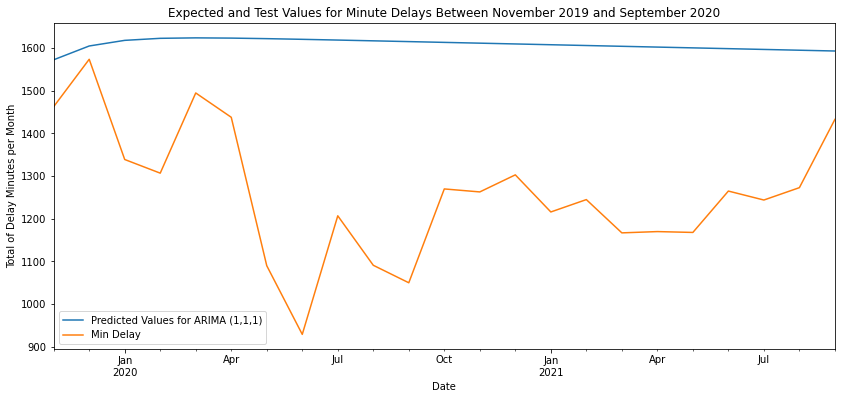

In [181]:
prediction.plot(legend = True, figsize=(14,6), title = 'Expected and Test Values for Minute Delays Between November 2019 and September 2020')
test.plot(legend=True, ylabel= 'Total of Delay Minutes per Month')

As seen both ways, the model seems to be a bit off in its ability to predict the values for the test set. Let's run some evaluation metrics to dig deeper on this.

In [187]:
print(mean_absolute_error(test, prediction))
print(np.sqrt(mean_squared_error(test, prediction)))

348.0055101599215
379.93842559538143


In [186]:
test.describe()

count      23.000000
mean     1260.869565
std       152.074833
min       929.000000
25%      1169.000000
50%      1263.000000
75%      1323.000000
max      1574.000000
Name: Min Delay, dtype: float64

Predictions are about 380 minutes off in relation to the mean, so it seems like a steep difference. This ARIMA model has performed worse than the Holt-Winters method I implemented earlier. Let's forecast six months ahead, regardless.

In [196]:
#train the model
final_model= ARIMA(df_total_monthly['Min Delay'], order =(1,1,1))
final_results= final_model.fit()
forecast = final_results.predict(len(df_total_monthly), len(df_total_monthly)+6, typ='levels').rename('6-month Forecast Using ARIMA(1,1,1)')
forecast

C:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


2021-10-31    1335.901237
2021-11-30    1295.512673
2021-12-31    1276.813063
2022-01-31    1266.408447
2022-02-28    1259.176272
2022-03-31    1253.157405
2022-04-30    1247.602570
Freq: M, Name: 6-month Forecast Using ARIMA(1,1,1), dtype: float64

<AxesSubplot:title={'center':'6-month Fprecast of Monthly TTC Minute Delays'}, xlabel='Date', ylabel='Monthly Minute Delays'>

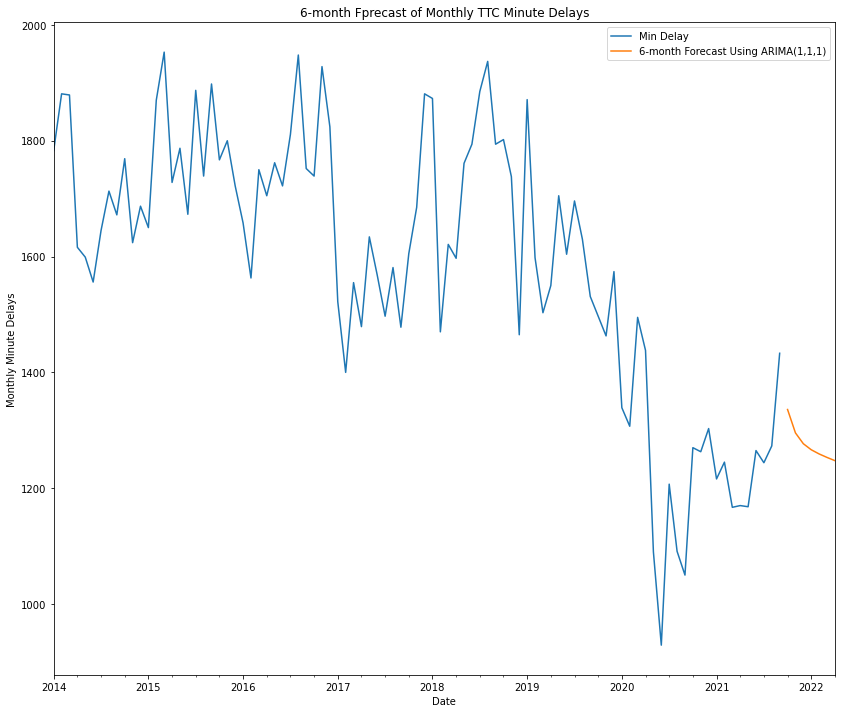

In [198]:
#plot forecast and data together
df_total_monthly['Min Delay'].plot(legend=True, title = '6-month Fprecast of Monthly TTC Minute Delays', ylabel= 'Monthly Minute Delays')
forecast.plot(legend=True)

Unlike the Holt-winters forecast, the trend shown here is remarkably downward, assuming values will be below accurent average at the start of 2022.